# Gradient descent training of a rate-based reservoir model

## Requirements

In [1]:
# - Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# - Imports and boilerplate 
from rockpool import TimeSeries, TSContinuous
from rockpool.layers import RecRateEulerJax_IO, H_ReLU, H_tanh
from tqdm import tnrange
from tqdm.autonotebook import tqdm

import numpy as np
import numpy.random as npr

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

## Triggered signal-generation task

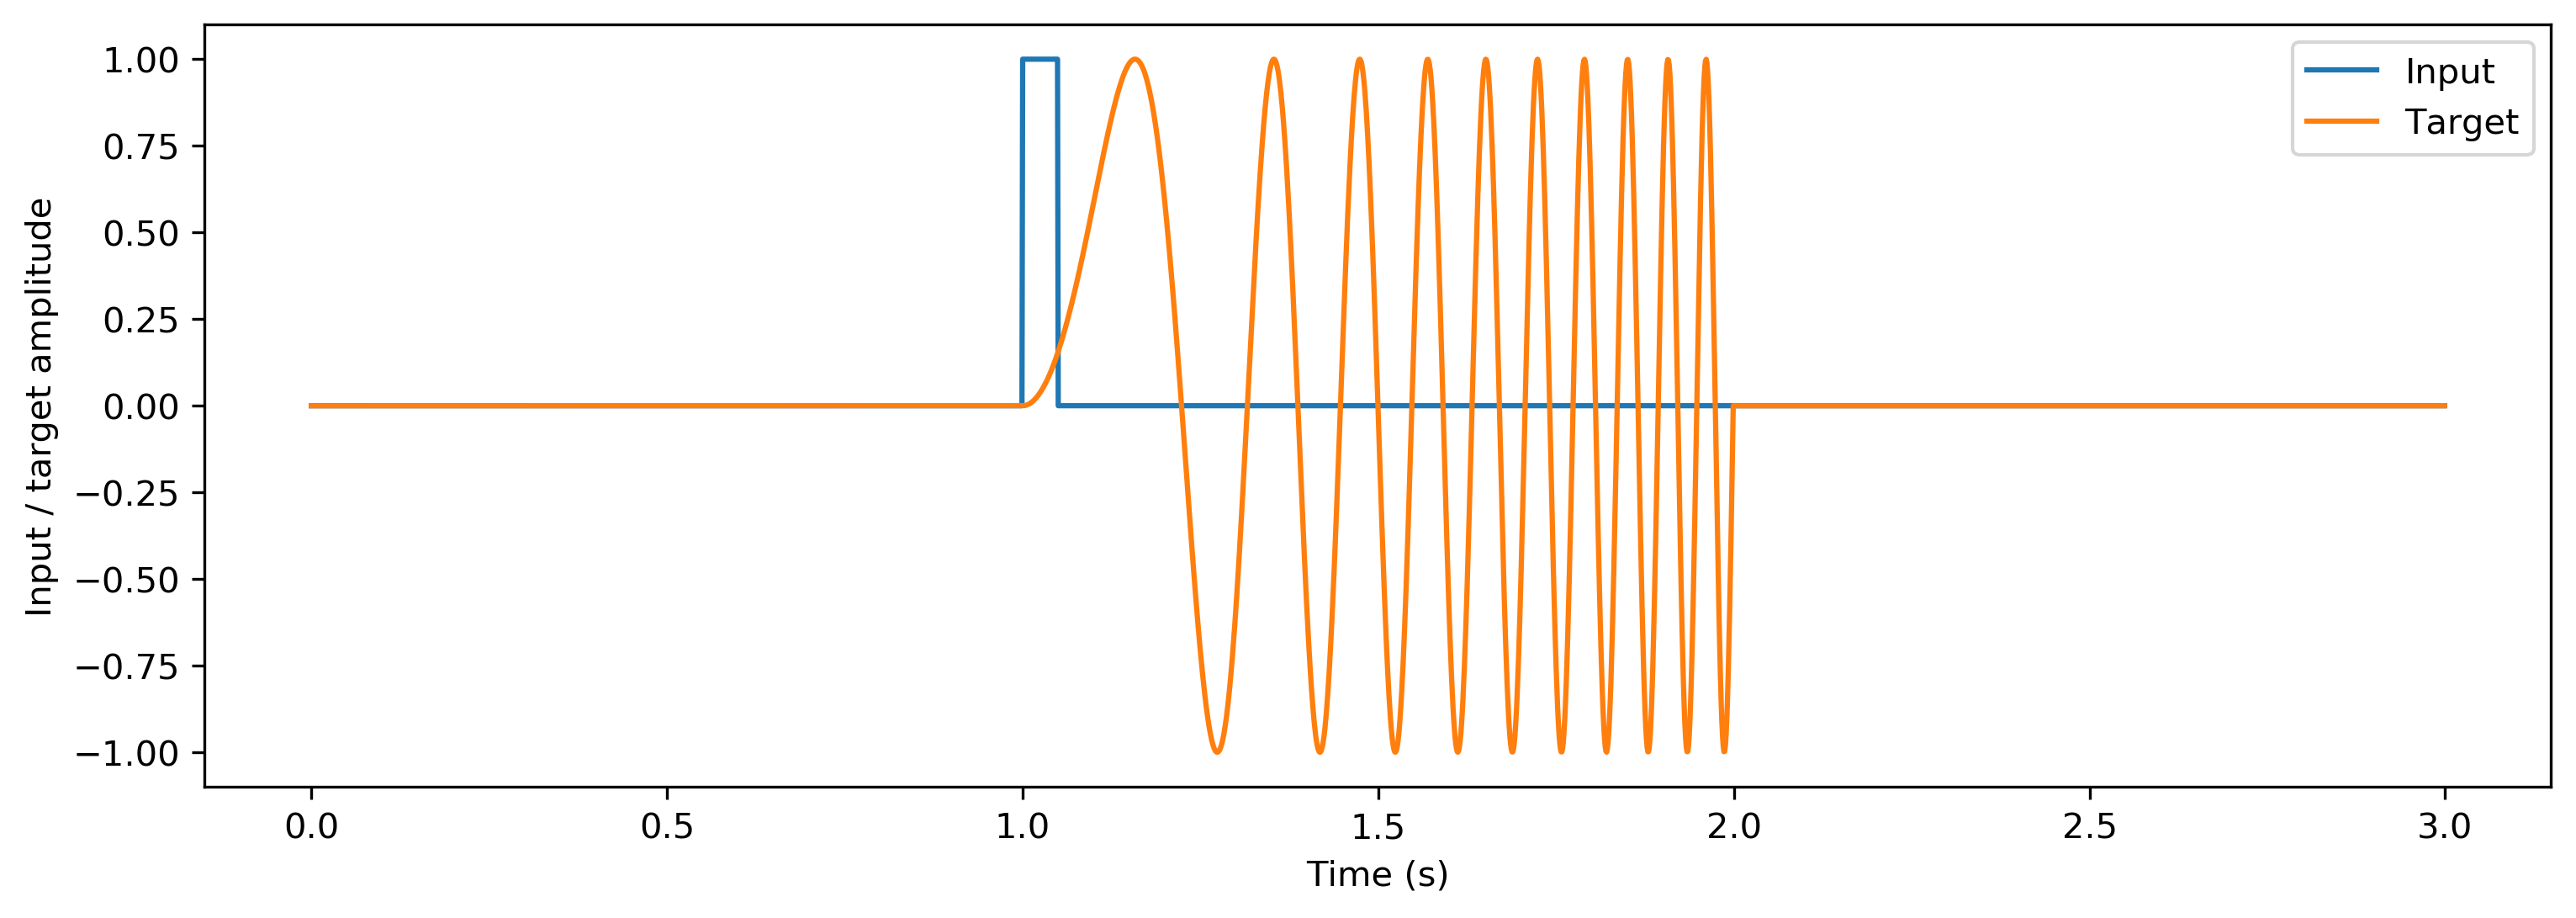

In [2]:
# - Define input and target signals 
num_repeats = 1
pulse_duration = 50e-3
chirp_freq_factor = 10
padding_duration = 1
chirp_duration = 1
dt = 1e-3

# - Build chirp and trigger signals
chirp_end = int(np.round(chirp_duration / dt))
chirp_timebase = np.linspace(0, chirp_end * dt, chirp_end)
chirp = np.atleast_2d(np.sin(chirp_timebase * 2 * np.pi * (chirp_timebase * chirp_freq_factor))).T
trigger = np.atleast_2d(chirp_timebase < pulse_duration).T

# - Add padding
padding = np.zeros((int(np.round(padding_duration / dt)), 1))
chirp = np.vstack((padding, chirp, padding))
trigger = np.vstack((padding, trigger, padding))

# - Build a time base
num_samples = (chirp_end + len(padding)*2) * num_repeats
timebase = np.linspace(0, num_samples, num_samples + 1)
timebase = timebase[:-1] * dt

# - Replicate out inputs and target signals
input_t = np.tile(trigger * 1., (num_repeats, 1))
target_t = np.tile(chirp, (num_repeats, 1))

# - Generate time series objects
ts_input = TSContinuous(timebase, input_t, periodic=True)
ts_target = TSContinuous(timebase, target_t, periodic=True)

# - Plot the input and target signals
plt.figure()
plt.plot(
     timebase,
     input_t,
     timebase,
     target_t,
     # timebase, target_t + np.diff(np.vstack((target_t, target_t[0])), axis=0) / dt * tau,
 )
plt.xlabel('Time (s)')
plt.ylabel('Input / target amplitude')
plt.legend(("Input", "Target"));

## Network model

The dynamics of a unit $j$ in the recurrent layer is given by

$$
\tau_j\frac{\textrm{d}{x_j}}{\textrm{d}t} + {x_j} = W_r \cdot f(\textbf{x}) + b_j + i_j + \sigma\zeta_j(t)
$$

where $\tau_j$ is the time constant of the unit (`tau`); $W_r$ is the $N \times N$ weight matrix defining the recurrent connections; $\textbf{x}$ is the vector of recurrent layer activities (`w_rec`); $f(x)$ is the neuron transfer function $\tanh(x)$; $b_j$ is the bias input of the unit (`bias`); $i_j$ is the external input to the unit; and $\sigma\zeta_j(t)$ is a white noise process with standard deviation $\sigma$ (`noise_std`).

External input is weighted such that $\textbf{i} = W_i \cdot i(t)$, where $W_i$ is the external input weight matrix (`w_in`) and $i(t)$ is the external input function.

The output of the reservoir is also weighted such that $z = W_o \cdot \textbf{x}$, where $W_o$ is the output weight matrix (`w_out`). The goal of the training task is to match the reservoir output $\hat{z}$ with a target signal $z^*$.

Weight initialisation doesn't seem to matter too much in this process; gradient descent does a good job even when weights are initially zero. Here we use a standard initialisation with unit spectral radius for the recurrent weights.

You can change the activation function to one of `H_tanh` or `H_ReLU`. You can also define your own, but must use `jax.numpy` to do so.

In [3]:
# - Define the reservoir parameters
nResSize = 100
tau = 20e-3
bias = 0.
activation_func = H_ReLU
noise_std = 0.1

# - Build a layer
nInSize = 1
nOutSize = 1
w_in = 2*npr.rand(nInSize, nResSize)-1
w_rec = npr.randn(nResSize, nResSize) / np.sqrt(nResSize)
w_out = 2*npr.rand(nResSize, nOutSize)-1

lyrRes = RecRateEulerJax_IO(w_in, w_rec, w_out, tau, bias,
                            dt = dt, noise_std = noise_std,
                            activation_func = activation_func)

# - Get initial output
ts_output0 = lyrRes.evolve(ts_input)

In [4]:
# - Force initialisation of training
l, g, o = lyrRes.train_output_target(ts_input, ts_target, is_first = True);

The loss function is a combination of mean-squared-error between the reservoir output and the target signal $\frac{1}{T} (\hat{z} - z^*)^2$; a factor that harshly penalises time constants $\tau$ shorter than the minimum time constant $\tau_{min}$; and a factor related to the 2-norm of the recurrent weight matrix `np.mean(w_recurrent ** 2)` or $||W_r||^2$. This helps to ensure that the network remains stable.

At the end of each batch the network is testing by providing a pulse input, and plotting the reservoir response.

In [5]:
num_batches = 10
trials_per_batch = 200

def two_norm(params):
    return np.sqrt(np.sum([np.sum(e ** 2) for e in params.values()]))

with tnrange(num_batches, desc='batches') as tqdm_batches:
    for _ in range(num_batches):
        with tnrange(trials_per_batch, desc='trials', leave=False) as tqdm_trials:
            for _ in range(trials_per_batch):
                # - Get this trial
                pass

                # - One step of Adam training
                loss, grad_loss, output = lyrRes.train_output_target(ts_input, ts_target)

                # - Update statistics
                tqdm_trials.set_postfix(loss=loss(),
                                        #norm_g=two_norm(grad_loss()),
                                        min_tau=int(np.min(lyrRes.tau) / 1e-3),
                                        refresh=False)
                tqdm_trials.update()
            
            # - Update batch progress
            tqdm_batches.update()

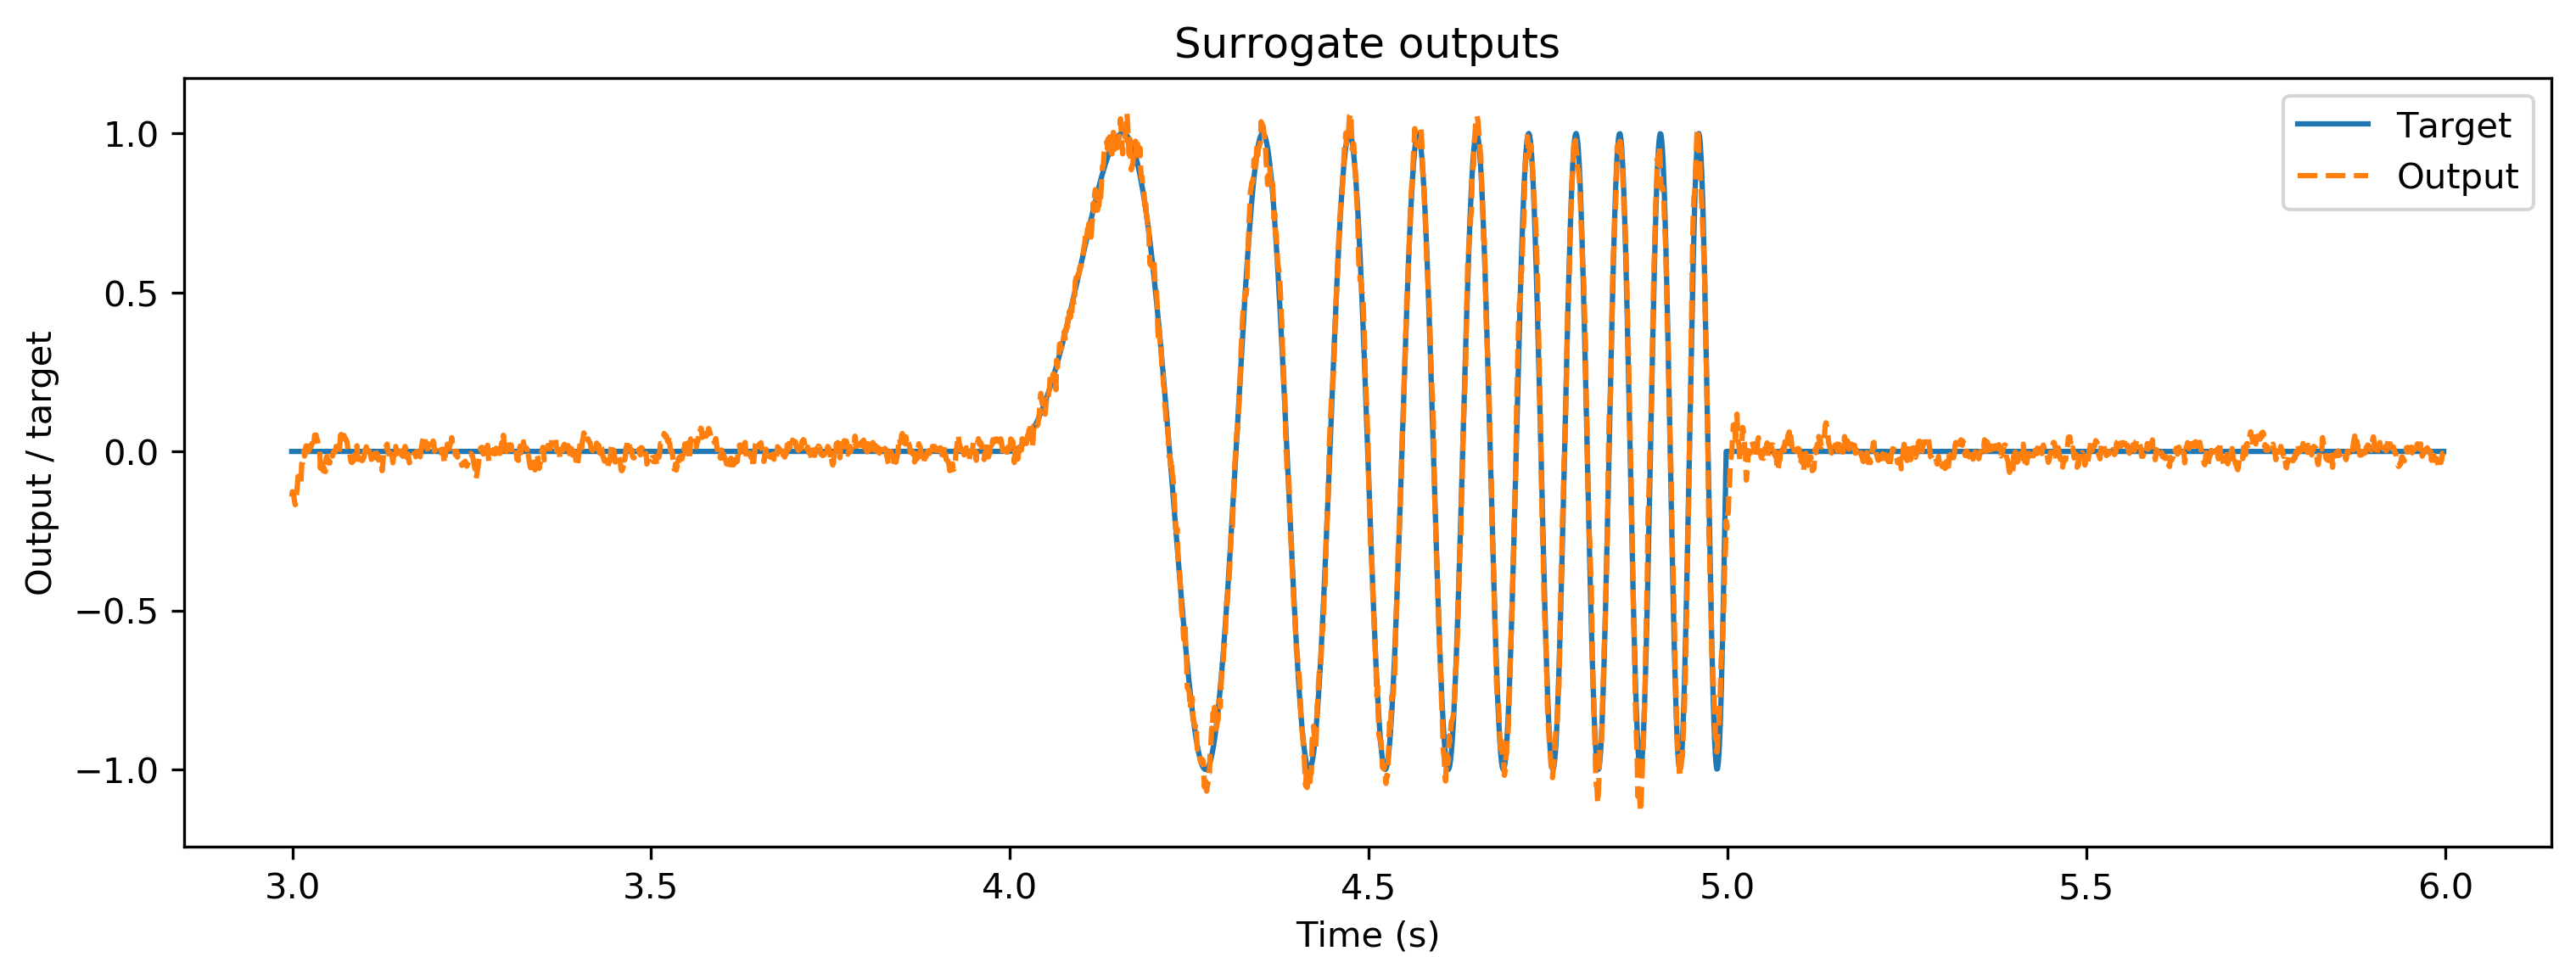

In [6]:
plt.figure()
ts_output = lyrRes.evolve(ts_input)
plt.plot(ts_output.times, ts_target(ts_output.times))
ts_output.plot(ls = '--')
plt.legend(['Target', 'Output'])
plt.xlabel('Time (s)')
plt.ylabel('Output / target');

If all has gone according to plan, the output of the reservoir should closely match the target signal. We can see the effect of training by examining the distribution of network parameters below.

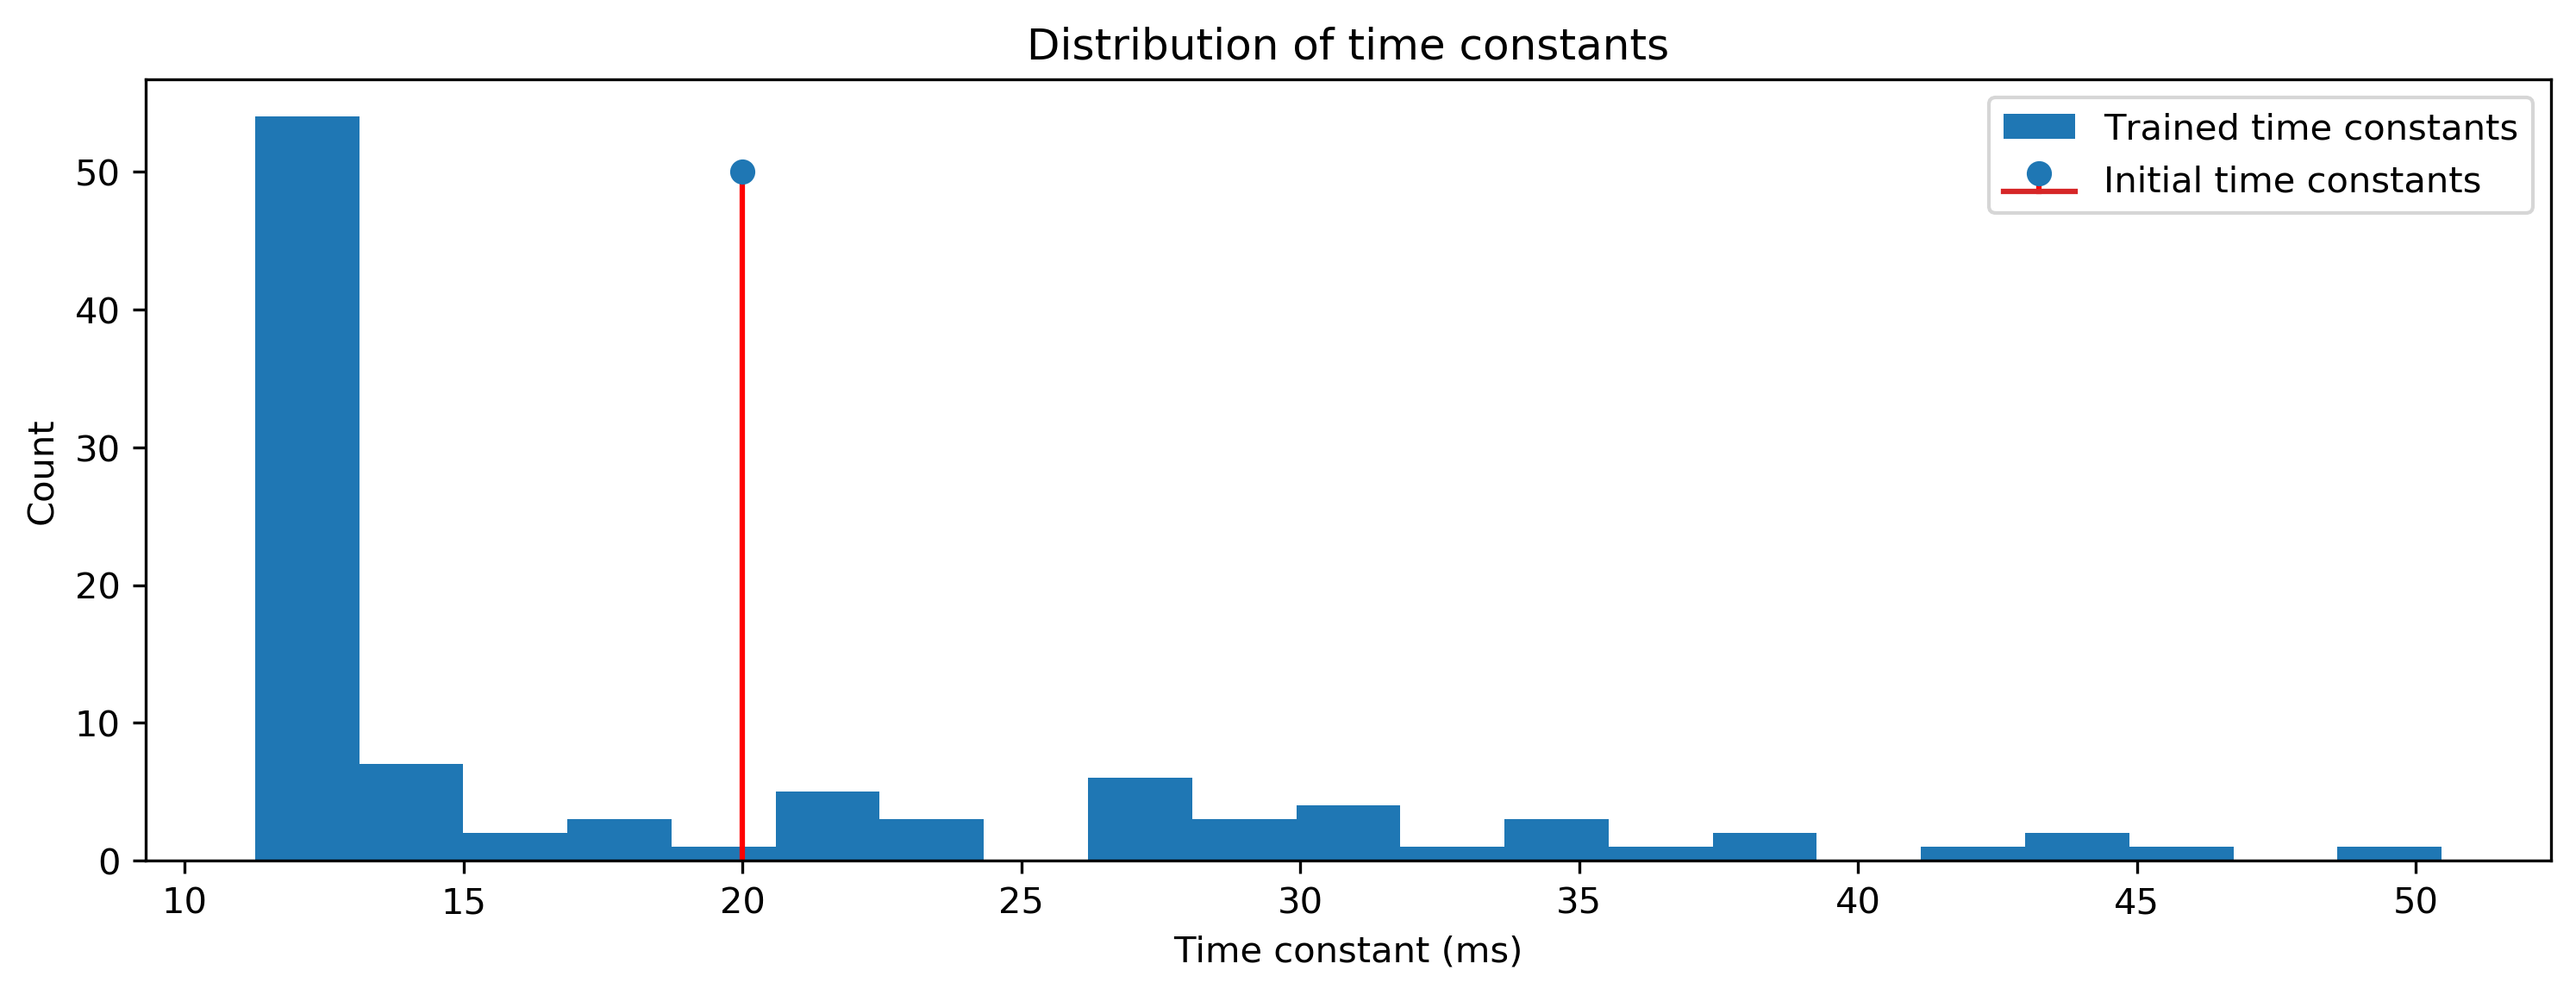

In [7]:
# - Plot the network time constants
plt.figure()
plt.hist(lyrRes.tau / 1e-3, 21);
plt.stem([tau / 1e-3], [50], 'r-')
plt.legend(('Trained time constants', 'Initial time constants'))
plt.xlabel('Time constant (ms)');
plt.ylabel('Count');
plt.title('Distribution of time constants');

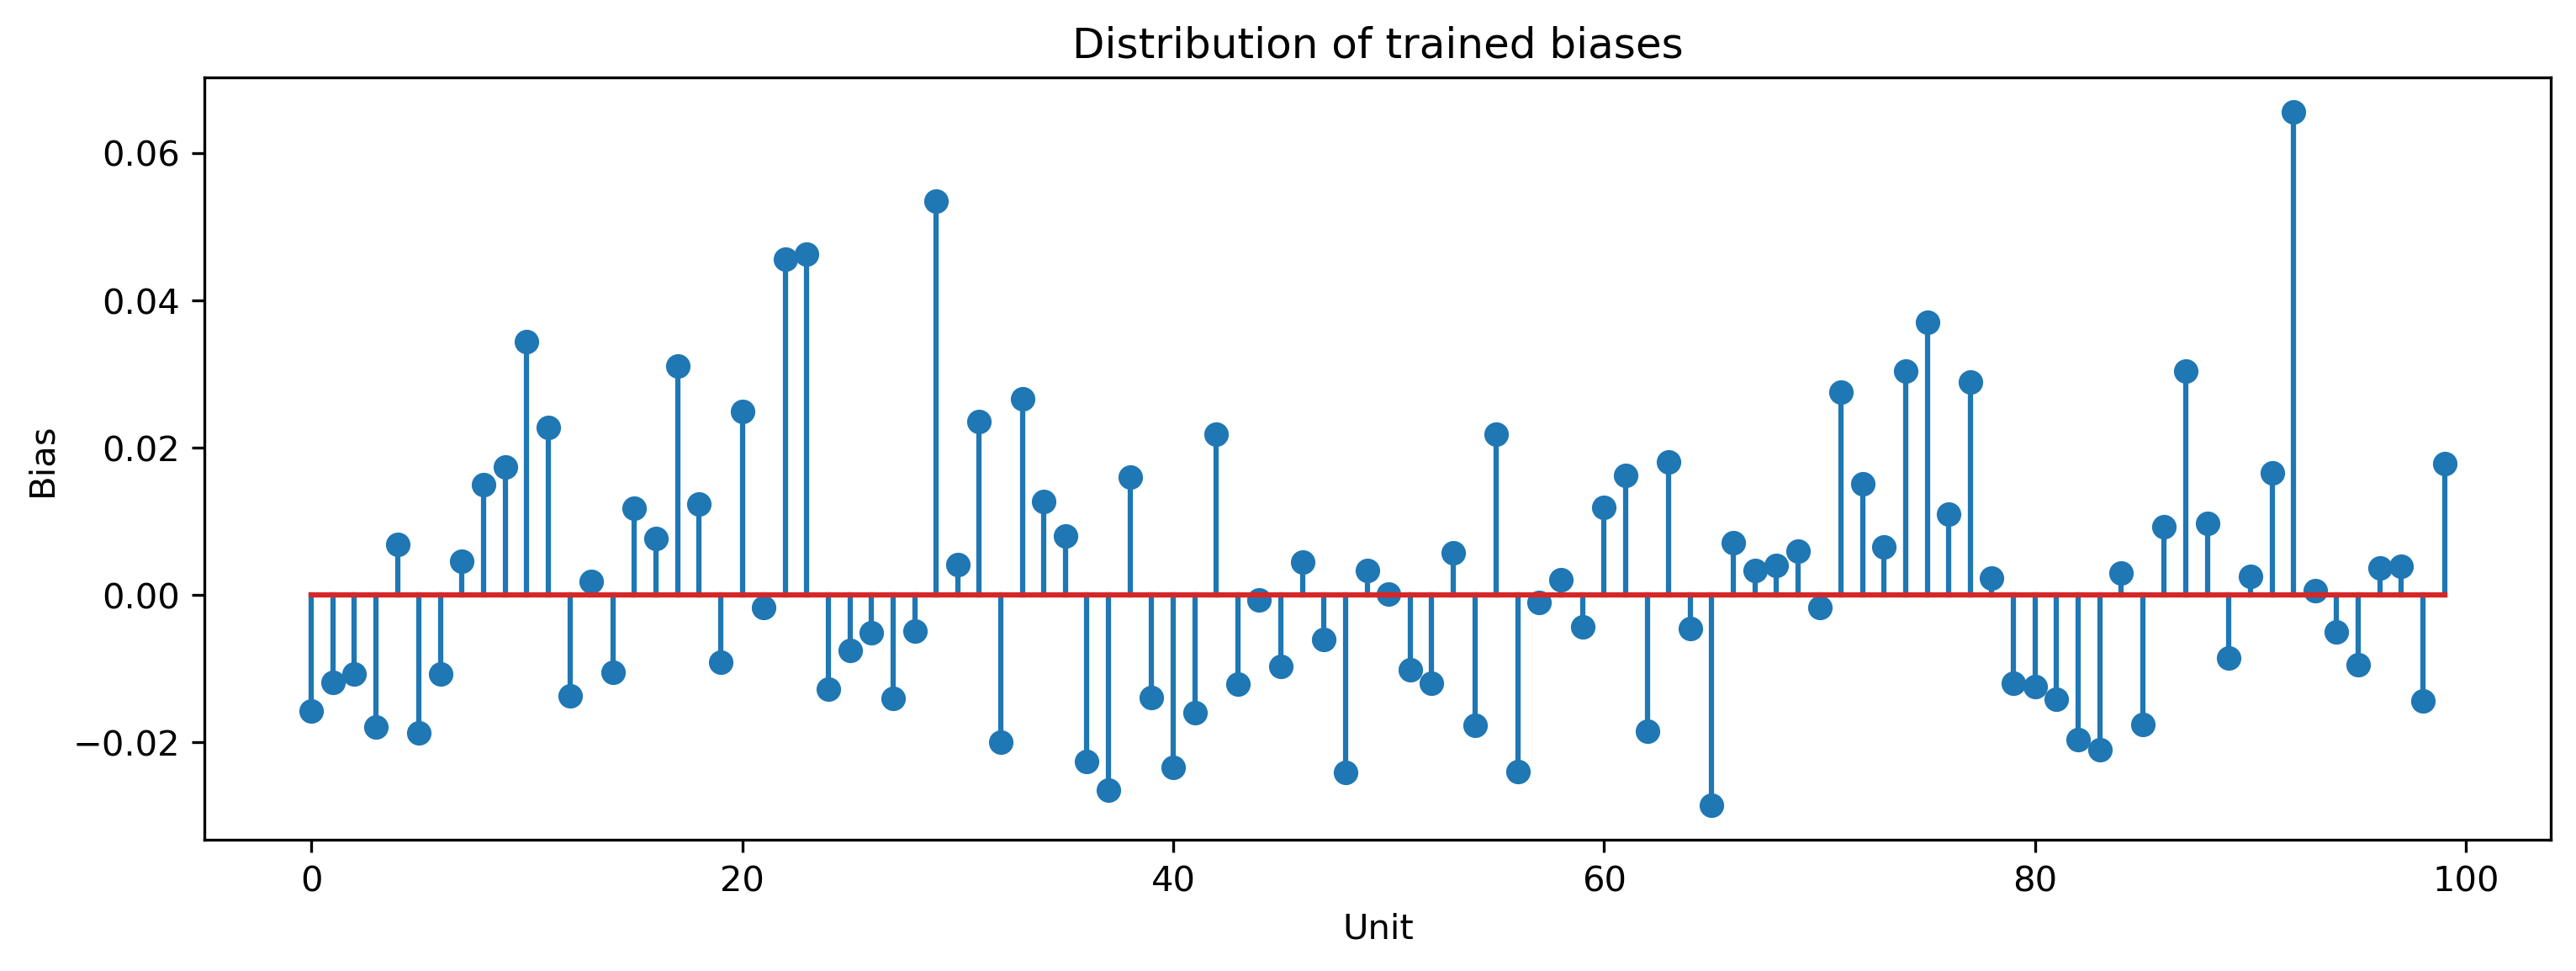

In [8]:
# - Plot the recurrent layer biases
plt.figure()
plt.stem(lyrRes.bias);
plt.title('Distribution of trained biases')
plt.xlabel('Unit')
plt.ylabel('Bias');

We can examine something of the computational properties of the network by finding the eigenspectrum of the Jacobian of the recurrent layer. The Jacobian $\hat{J}$ is given by

$$
\hat{J} = (\hat{W_r} - I) ./ \hat{T}
$$

where $I$ is the identity matrix, $./$ denotes element-wise division, and $T$ is the matrix composed of all time constants $\hat{\tau}$ of the recurrent layer.

Below we plot the eigenvalues $\lambda$ of $J$. In my training result, several complex eigenvalues $\lambda$ with real parts greater than zero are present in the trained eigenspectrum. These correspond to oscillatory modes, which are obviously useful in generating the chirp output.

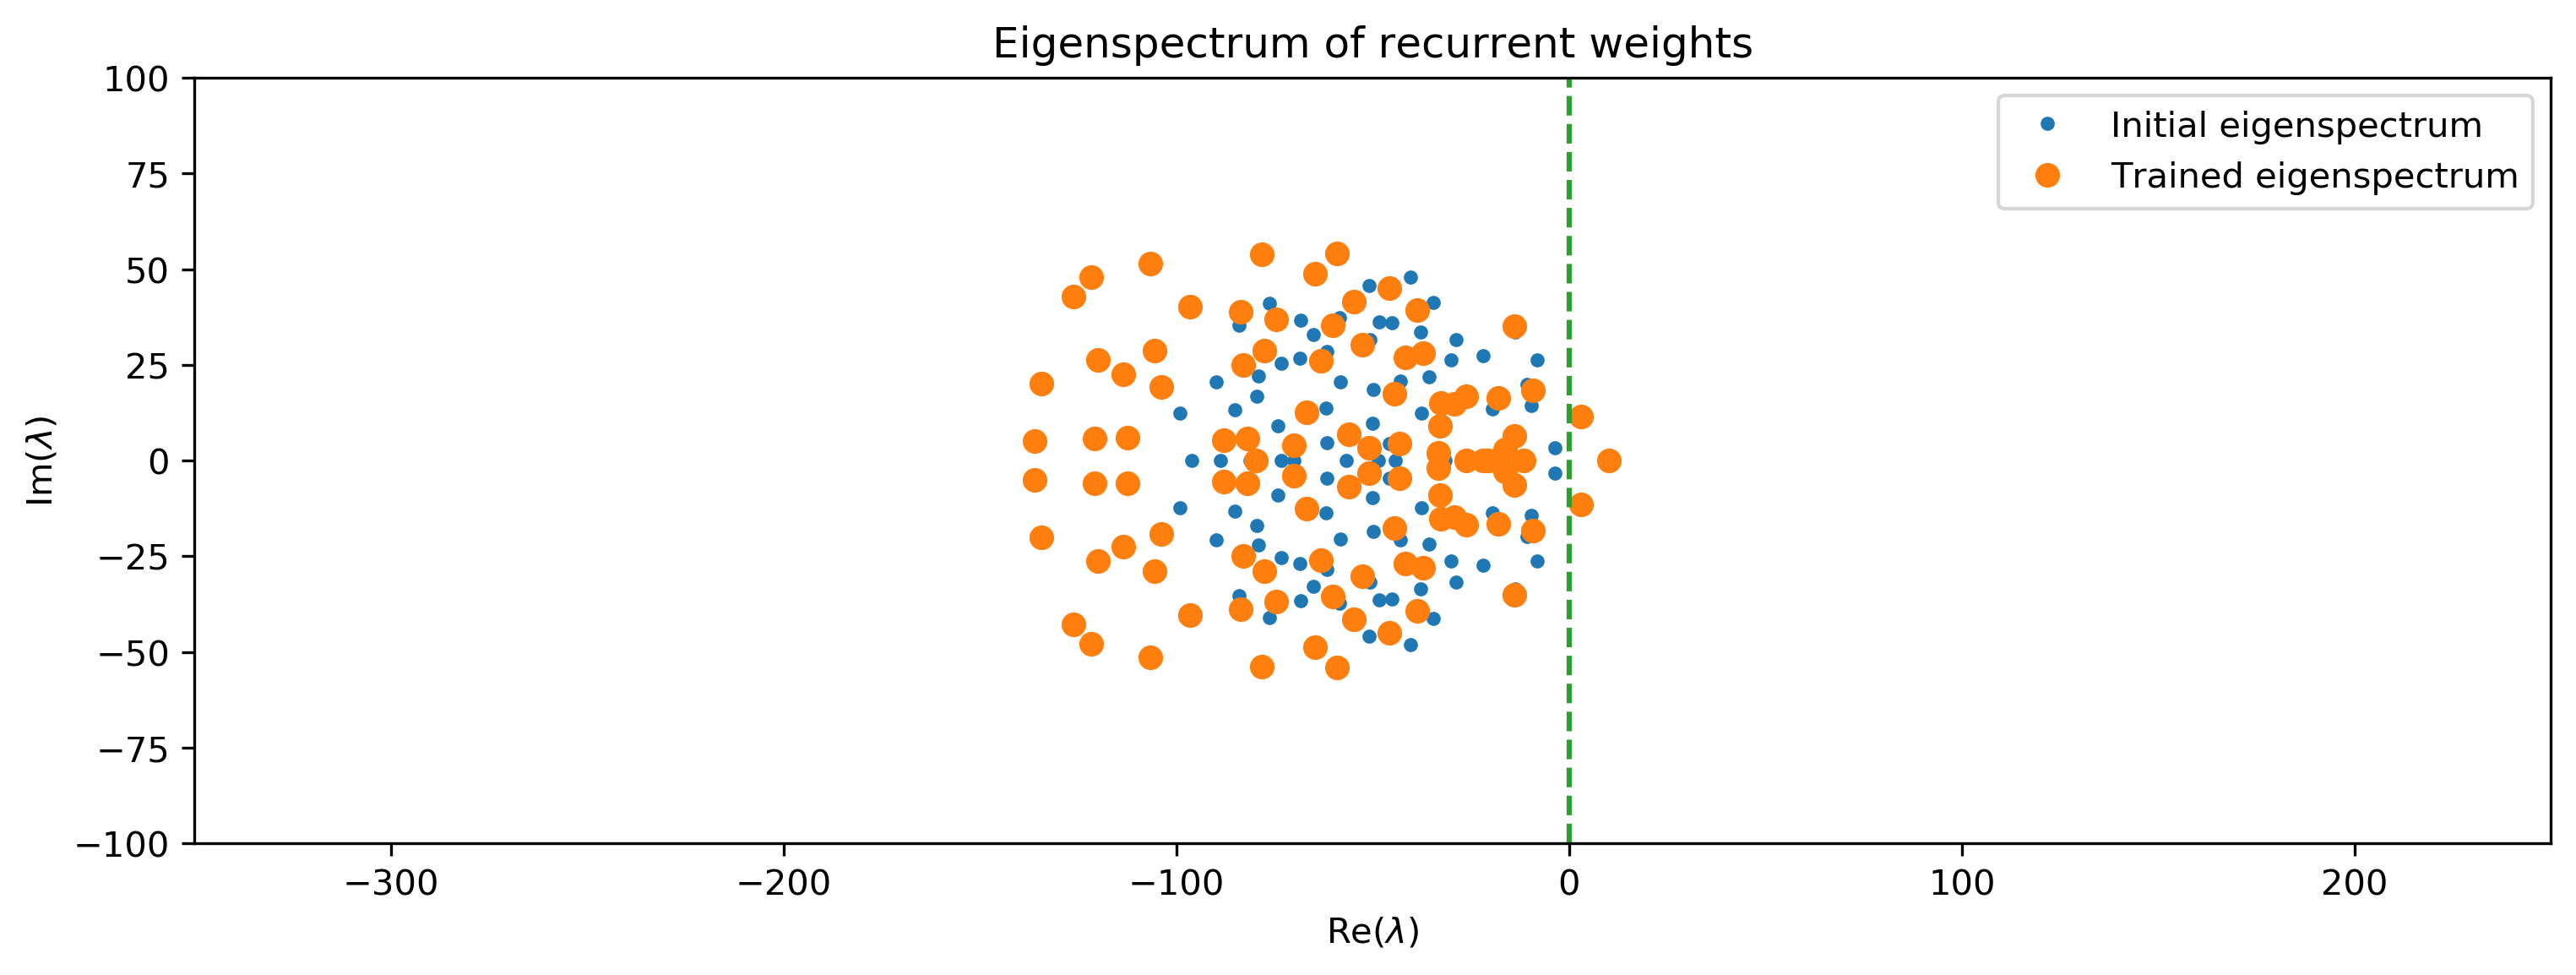

In [9]:
# - Plot the recurrent layer eigenspectrum 
J = lyrRes.w_recurrent - np.identity(nResSize)
J = J / lyrRes.tau

J0 = w_rec - np.identity(nResSize)
J0 = J0 / tau

plt.figure()
eigs = np.linalg.eigvals(J)
eigs0 = np.linalg.eigvals(J0)
plt.plot(np.real(eigs0), np.imag(eigs0), '.')
plt.plot(np.real(eigs), np.imag(eigs), 'o')
plt.plot([0, 0], [-100, 100], '--')
plt.legend(('Initial eigenspectrum', 'Trained eigenspectrum',))
plt.xlim([-350, 250])
plt.ylim([-100, 100])
plt.title('Eigenspectrum of recurrent weights')
plt.xlabel('Re($\lambda$)')
plt.ylabel('Im($\lambda$)');

## Summary
Gradient descent training does a good job of optimmising a dynamic recurrent network for a difficult task requiring significant reservoir memory. `jax` provides a computationally efficient back-end as well as automatic differentiation of the recurrent reservoir layer.